In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration parameters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 10000
env = gym.make("MountainCar-v0")  # Create the environment
env.seed(seed)
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0

In [2]:
num_inputs = 2
num_actions = 3
num_hidden = 128

inputs = layers.Input(shape=(num_inputs,))
common_prec = layers.Dense(num_hidden, activation="relu")(inputs)
common = layers.Dense(round(num_hidden/2), activation="relu")(common_prec)
action = layers.Dense(num_actions, activation="softmax")(common)
critic = layers.Dense(1)(common)
helper_critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic, helper_critic])

2021-09-07 23:13:10.428676: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          384         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3)            195         dense_1[0][0]                    
______________________________________________________________________________________________

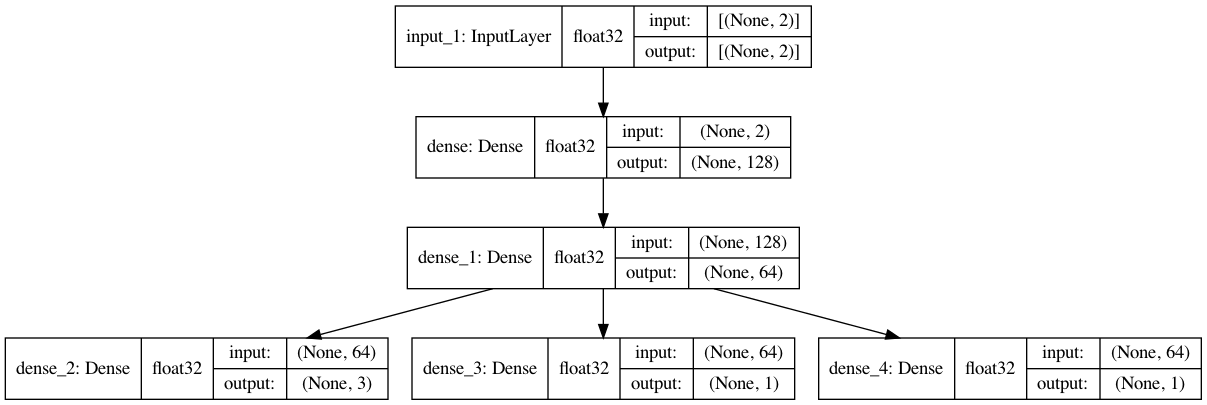

In [4]:
tf.keras.utils.plot_model(
    model,
#     to_file="model.png",
    show_shapes=1,
    show_dtype=1,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [14]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

# raoul new
episode_rewards_history = []
best_altitude_history = []
hcritic_value_history = []

while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    episode_highest = -2 # lower than lowest altitude
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            # env.render(); Adding this line would show the attempts
            # of the agent in a pop up window.

            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value, hcritic_value = model(state)
            critic_value_history.append(critic_value[0, 0])
            hcritic_value_history.append(hcritic_value[0, 0])

            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward
            
            # state 1 is the altitude... the higher the better
            episode_highest = max(episode_highest, state[1] - 0.6)
            best_altitude_history.append(episode_highest)
#             episode_highest = state[1] - 0.6 # 0.6 is the max altitude that can be reached
#             best_altitude_history.append(episode_highest)

            if done:
                break

        # Update running reward to check condition for solving
#         running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
        episode_rewards_history.append(episode_reward)
        running_reward = np.mean(episode_rewards_history[-100:])

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)
            
        hreturns = []
        hdiscounted_sum = 0
        for r in best_altitude_history[::-1]:
            hdiscounted_sum = r + gamma * hdiscounted_sum
            hreturns.insert(0, hdiscounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()
        
        hreturns = np.array(hreturns)
        hreturns = (hreturns - np.mean(hreturns)) / (np.std(hreturns) + eps)
        hreturns = hreturns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns, 
                      hcritic_value_history, hreturns)
        actor_losses = []
        critic_losses = []
        hcritic_losses = []
        for log_prob, value, ret, hval, hret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff * (hret - hval))  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )
            
            hcritic_losses.append(
                huber_loss(tf.expand_dims(hval, 0), tf.expand_dims(hret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses) + sum(hcritic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()
        best_altitude_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 10 == 0:
        template = "running reward: {:.2f} at episode {} (best over last 100: {}) (episode highest: {})"
        print(template.format(running_reward, episode_count, max(episode_rewards_history[-100:]),
                             round(episode_highest, 4)))

    # MountainCar-v0 is considered "solved" when the agent obtains an average reward 
    # of at least -110.0 over 100 consecutive episodes
    if running_reward > -110:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break


running reward: -200.00 at episode 10 (best over last 100: -200.0) (episode highest: -0.5847)
running reward: -200.00 at episode 20 (best over last 100: -200.0) (episode highest: -0.5827)


KeyboardInterrupt: 

In [17]:
env = gym.make("CartPole-v0")  # Create the environment
env.seed(seed)
state = env.reset()

for i in range(1, 1000):
    env.render(); # Adding this line would show the attempts
    # of the agent in a pop up window.

    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)

    # Predict action probabilities and estimated future rewards
    # from environment state
    action_probs, critic_value = model(state)

    # Sample action from action probability distribution
    action = np.random.choice(num_actions, p=np.squeeze(action_probs))

    # Apply the sampled action in our environment
    state, reward, done, info = env.step(action)

    if done:
        print(i)
        break
env.close()

2021-09-07 21:12:14.703 python[84606:5711452] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fcd38b2a040>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-09-07 21:12:14.704 python[84606:5711452] Warning: Expected min height of view: (<NSButton: 0x7fcd1a0c7bb0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-09-07 21:12:14.707 python[84606:5711452] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fcd192e2760>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-09-07 21:12:14.709 python[84606:5711452] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fcd19284b20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


200


In [12]:
critic_losses

[<tf.Tensor: shape=(), dtype=float32, numpy=0.38316643>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.3781098>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.37319636>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.36847275>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.3637684>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.35905677>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.35449943>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.35011476>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.34557185>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.340983>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.33636943>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.3317286>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.3269009>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.32186568>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.31662744>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.3114991>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.30652368>,
 <tf.Tensor: shape=(), dtype=float32, 

In [7]:
import gym
env = gym.make("MountainCar-v0")
for i_episode in range(1):
    observation = env.reset()
    for t in range(100):
        env.render()
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        print("obs:", observation)
        print("reward:", reward)
        print("action:", action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

2021-09-07 22:12:15.854 python[85175:5768702] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7faae4ed8000>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-09-07 22:12:15.856 python[85175:5768702] Warning: Expected min height of view: (<NSButton: 0x7faae8e9a1c0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-09-07 22:12:15.859 python[85175:5768702] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7faae98f32f0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-09-07 22:12:15.862 python[85175:5768702] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7faacc35c8c0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


obs: [-5.69080508e-01  3.42600990e-04]
reward: -1.0
action: 1
obs: [-5.69397851e-01 -3.17343466e-04]
reward: -1.0
action: 0
obs: [-0.56837278  0.00102507]
reward: -1.0
action: 2
obs: [-5.68012915e-01  3.59866044e-04]
reward: -1.0
action: 0
obs: [-0.56632093  0.00169199]
reward: -1.0
action: 2
obs: [-0.5653094   0.00101153]
reward: -1.0
action: 0
obs: [-5.6498586e-01  3.2354092e-04]
reward: -1.0
action: 0
obs: [-5.65352713e-01 -3.66852861e-04]
reward: -1.0
action: 0
obs: [-0.56440723  0.00094548]
reward: -1.0
action: 2
obs: [-5.64156447e-01  2.50782820e-04]
reward: -1.0
action: 0
obs: [-5.63602232e-01  5.54215374e-04]
reward: -1.0
action: 1
obs: [-0.56174871  0.00185352]
reward: -1.0
action: 2
obs: [-0.56060969  0.00113902]
reward: -1.0
action: 0
obs: [-0.55819365  0.00241603]
reward: -1.0
action: 2
obs: [-0.55651862  0.00167503]
reward: -1.0
action: 0
obs: [-0.5535971   0.00292153]
reward: -1.0
action: 2
obs: [-0.54945089  0.00414621]
reward: -1.0
action: 2
obs: [-0.54411098  0.0053399

In [10]:
model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(2, 128) dtype=float32, numpy=
 array([[ 0.09715028, -0.09125539,  0.02251536,  0.02906925,  0.06789096,
          0.11584009,  0.09023096,  0.1218944 , -0.04858947, -0.03052825,
         -0.02718582,  0.03793688, -0.02586369,  0.14438851,  0.10996474,
         -0.14412783, -0.16055468, -0.10511256,  0.05158101, -0.10951944,
          0.00951754,  0.00743612,  0.04472224, -0.0174064 ,  0.01067624,
          0.01780913,  0.06710704, -0.01616881, -0.07996768, -0.03558883,
         -0.0488222 ,  0.2029533 ,  0.07849909,  0.14188491,  0.20187397,
          0.11636956,  0.1304933 ,  0.08920409, -0.14795853,  0.11341982,
          0.03655629,  0.03352147, -0.18216346,  0.02615279,  0.2106158 ,
          0.02390483, -0.05396013,  0.04695345,  0.04181292,  0.20426382,
         -0.04095129,  0.0750414 ,  0.08729438,  0.06458043,  0.05163787,
         -0.06332106,  0.19248392,  0.04901831,  0.0047523 ,  0.07682509,
          0.17914651, -0.19560188, -0.096363

In [13]:
grads

[<tf.Tensor: shape=(2, 128), dtype=float32, numpy=
 array([[ 0.        ,  0.19975555,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.42426723,  0.32621115,  0.27444723,  0.        ,  0.2468451 ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.22023425,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.06227699,  0.        ,
          0.        ,  0.        ,  0.6648971 ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.6098873 ,  0.11785012,  0.        , 